##**Problem Statements:**

###**1:Identify Key Predictors:**
 Determine which features (such as income, employment length, debt-to-income ratio, etc.) have the most significant impact on the loan amount approved for customers.
###**2:Build a Predictive Model:**
Develop a linear regression model that utilizes the identified predictors to accurately predict the loan amounts that customers are likely to receive.

###**3:Interpret Coefficients:**
Interpret the coefficients of the linear regression model to understand the magnitude and direction of the impact of each predictor variable on the loan amount. This helps in understanding which factors contribute most to loan approval decisions.

###**4: Optimize Loan Approval Process:**
Make the loan approval process smoother and more efficient by using information from the predictive model. By paying attention to the factors that have the biggest impact on loan approval, lenders can make better decisions while also keeping risks low and following regulations.


##**Analytics Solution:**

###**The loan amount prediction problem will be addressed using a linear regression model. This model will be trained on historical data containing features such as employment length, income, loan term, interest rate, and other relevant variables. The goal is to develop a model that accurately predicts the loan amount a customer is eligible for based on their profile.**

##**Data Used**

In [236]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder \
   .appName("linear_regression") \
   .getOrCreate()

train_data = spark.read.format("csv") \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .load("file:///content/drive/MyDrive/archive (5)/nepali/financial_loan.csv")
train_data.show(5)





+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|     id|address_state|application_type|emp_length|           emp_title|grade|home_ownership|issue_date|last_credit_pull_date|last_payment_date|loan_status|next_payment_date|member_id|purpose|sub_grade|      term|verification_status|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|1077430|           GA|      INDIVIDUAL|  < 1 year|             

In [237]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.appName("Drop Columns Example").getOrCreate()

# Sample DataFrame for illustration (assuming train_data is your DataFrame)


columns = [
    'id', 'address_state', 'application_type', 'emp_length', 'emp_title', 'grade',
    'home_ownership', 'issue_date', 'last_credit_pull_date', 'last_payment_date',
    'loan_status', 'next_payment_date', 'member_id', 'purpose', 'sub_grade', 'term',
    'verification_status', 'annual_income', 'dti', 'installment', 'int_rate',
    'loan_amount', 'total_acc', 'total_payment'
]

# Drop the columns 'id' and date-related columns
columns_to_drop = ['id', 'issue_date', 'last_credit_pull_date', 'last_payment_date', 'next_payment_date','member_id']
cleaned_df = train_data.drop(*columns_to_drop)




##**Data Preperation**

###**1: Remove Null value from all the columns**



In [238]:
cleaned_df = cleaned_df.na.drop(subset=['address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment'])

###**2: Encode categorical features:**
Transform the "emp_length" column by replacing "10+ years" with 15, "< 1 year" with 5, and for all other values, use regexp_replace() to remove " years" or " year" and cast the result to an integer.

In [145]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, regexp_replace, col

# Create a SparkSession
spark = SparkSession.builder.appName("Transform emp_length").getOrCreate()



# Transform the emp_length column
transformed_df = cleaned_df.withColumn(
    "emp_length",
    when(col("emp_length") == "10+ years", 15)
    .when(col("emp_length") == "< 1 year", 5)
    .otherwise(regexp_replace(col("emp_length"), " years| year", "").cast("int"))
)

# Show the final DataFrame
transformed_df.select('emp_length').show(5)



+----------+
|emp_length|
+----------+
|         5|
|         9|
|         4|
|         5|
|        15|
+----------+
only showing top 5 rows



###**3: Data Transformation using String Indexer:**
String Indexer convert string categorical columns to numerical indices using StringIndexer for further processing in Spark ML.

In [146]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder \
    .appName("StringIndexer Example") \
    .getOrCreate()

# Cast the necessary columns to string (if not already)
df = transformed_df.withColumn("address_state", col("address_state").cast("string")) \
                   .withColumn("application_type", col("application_type").cast("string"))\
                   .withColumn("emp_length", col("emp_length").cast("string")) \
                   .withColumn("emp_title", col("emp_title").cast("string")) \
                   .withColumn("grade", col("grade").cast("string")) \
                   .withColumn("home_ownership", col("home_ownership").cast("string")) \
                   .withColumn("loan_status", col("loan_status").cast("string")) \
                   .withColumn("purpose", col("purpose").cast("string")) \
                   .withColumn("sub_grade", col("sub_grade").cast("string")) \
                   .withColumn("term", col("term").cast("string")) \
                   .withColumn("verification_status", col("verification_status").cast("string"))

# Apply StringIndexer
indexer = StringIndexer(inputCols=["address_state", "application_type", "emp_length", "emp_title",
                                   "grade", "home_ownership", "loan_status", "purpose",
                                   "sub_grade", "term", "verification_status"],
                        outputCols=["address_state_indexed", "application_type_indexed",
                                    "emp_length_indexed", "emp_title_indexed", "grade_indexed",
                                    "home_ownership_indexed", "loan_status_indexed",
                                    "purpose_indexed", "sub_grade_indexed", "term_indexed",
                                    "verification_status_indexed"]).fit(df)

# Transform the DataFrame
indexed_df = indexer.transform(df)

# Rearrange columns to place indexed columns next to their original columns
for original_col, indexed_col in zip(indexer.getInputCols(), indexer.getOutputCols()):
    indexed_df = indexed_df.withColumn(indexed_col, col(indexed_col)).withColumnRenamed(indexed_col, original_col + "_indexed")

# Select the columns in the desired order
final_columns = []
for col_name in df.columns:
    final_columns.append(col_name)
    if col_name in indexer.getInputCols():
        final_columns.append(col_name + "_indexed")

# Display the final DataFrame
indexed_df = indexed_df.select(final_columns)
indexed_df.show(5)


+-------------+---------------------+----------------+------------------------+----------+------------------+--------------------+-----------------+-----+-------------+--------------+----------------------+-----------+-------------------+-------+---------------+---------+-----------------+----------+------------+-------------------+---------------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|address_state|address_state_indexed|application_type|application_type_indexed|emp_length|emp_length_indexed|           emp_title|emp_title_indexed|grade|grade_indexed|home_ownership|home_ownership_indexed|loan_status|loan_status_indexed|purpose|purpose_indexed|sub_grade|sub_grade_indexed|      term|term_indexed|verification_status|verification_status_indexed|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------------+---------------------+----------------+------------------------+----------+------------------+---------

###**4: Data Reduction:**
Remove unnecessary columns from a DataFrame that are not required for further processing

In [147]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Column Selection and CSV Write") \
    .getOrCreate()

# Assuming your DataFrame is named 'indexed_df'
# Extract the desired columns
selected_columns = ['annual_income','dti','installment','int_rate','loan_amount', 'total_acc','total_payment','address_state_indexed',
 'application_type_indexed',
 'emp_length_indexed',
 'emp_title_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed']
selected_df = indexed_df.select(selected_columns)

# Save the selected columns to a new CSV file
selected_df.write.csv('selected_data.csv', header=True, mode='overwrite')





In [148]:
data1=selected_df.groupby('address_state_indexed').count()
#data1.show()
data2=selected_df.groupby('emp_length_indexed').count()
#data2.show()
data3=selected_df.groupby('emp_title_indexed').count()
#data3.show()
data4=selected_df.groupby( 'grade_indexed').count()
#data4.show()
data4=selected_df.groupby('loan_status_indexed').count()
#data4.show()
data4=selected_df.groupby('purpose_indexed').count()
#data4.show()
data5=selected_df.groupby('sub_grade_indexed').count()
#data5.show()
data5=selected_df.groupby( 'term_indexed').count()
#data5.show()
data6=selected_df.groupby('verification_status_indexed').count()
#data6.show()

In [239]:
# from pyspark.sql.functions import desc, asc

# df_multi_ordered = data1.orderBy(desc("count"))
# df_multi_ordered.show(5)

# df_multi_ordered2 = data2.orderBy(desc("count"))
# df_multi_ordered2.show(5)


# df_multi_ordered3 = data3.orderBy(desc("count"))
# df_multi_ordered3.show(5)


# df_multi_ordered4 = data4.orderBy(desc("count"))
# df_multi_ordered4.show(5)

# df_multi_ordered5 = data5.orderBy(desc("count"))
# df_multi_ordered5.show(5)

# df_multi_ordered6 = data6.orderBy(desc("count"))
# df_multi_ordered6.show(5)

In [150]:
#df.show(5)

###**5: Preprocess categorical data by identifying the top 4 most frequent categories and replacing any other categories with a fixed value of 5.0. Also, group categories with fewer than 200 occurrences into the least represented category.**


In [248]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Initialize Spark session
spark = SparkSession.builder.appName("Category Frequency Transformation").getOrCreate()

# Load the data
df = spark.read.csv("preprocessed_data.csv", header=True, inferSchema=True)

# Define the columns to preprocess
columns_to_preprocess = ['address_state_indexed',
 'application_type_indexed',
 'emp_length_indexed',
 'emp_title_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed']

# Preprocess each column
for column in columns_to_preprocess:
    # Calculate the frequency of each category
    freq_df = df.groupBy(column).count().orderBy(col("count").desc())

    # Identify categories with less than 200 occurrences
    low_freq_categories = freq_df.filter(col("count") < 200).select(column).rdd.flatMap(lambda x: x).collect()

    # Find the least highest frequency cluster that is greater than or equal to 200
    high_freq_clusters = freq_df.filter(col("count") >= 200).orderBy(col("count").asc())
    least_high_freq_cluster_row = high_freq_clusters.first()

    if least_high_freq_cluster_row:
        least_high_freq_cluster = least_high_freq_cluster_row[column]

        # Replace low-frequency categories with the least highest frequency cluster
        df = df.withColumn(column, when(col(column).isin(low_freq_categories), least_high_freq_cluster).otherwise(col(column)))
    else:
        print(f"No categories in column {column} with count >= 200")

# Save the preprocessed data
df.write.csv("preprocessed_data1.csv", header=True, mode="overwrite")

# Display the first few rows of the preprocessed data


In [241]:
data1=df.groupby('address_state_indexed').count()
#data1.show()
data2=df.groupby('application_type_indexed').count()
#data2.show()
data3=df.groupby('emp_length_indexed').count()
#data3.show()
data4=df.groupby('emp_title_indexed').count()
#data4.show()
data5=df.groupby('grade_indexed').count()
#data5.show()
data6=df.groupby('home_ownership_indexed').count()
#data6.show()
data7=df.groupby('loan_status_indexed').count()
#data7.show()
data8=df.groupby('purpose_indexed').count()
#data8.show()
data9=df.groupby('sub_grade_indexed').count()
#data9.show()
data9=df.groupby('term_indexed').count()
#data9.show()
data10=df.groupby('verification_status_indexed').count()
#data10.show()


In [242]:
from pyspark.sql.functions import desc, asc

df_multi_ordered = data1.orderBy(desc("count"))
df_multi_ordered.show(5)

df_multi_ordered2 = data2.orderBy(desc("count"))
df_multi_ordered2.show(5)


df_multi_ordered3 = data3.orderBy(desc("count"))
df_multi_ordered3.show(5)


df_multi_ordered4 = data4.orderBy(desc("count"))
df_multi_ordered4.show(5)

df_multi_ordered5 = data5.orderBy(desc("count"))
df_multi_ordered5.show(5)

df_multi_ordered6 = data6.orderBy(desc("count"))
df_multi_ordered6.show(5)

df_multi_ordered7 = data7.orderBy(desc("count"))
df_multi_ordered7.show(5)

df_multi_ordered8 = data8.orderBy(desc("count"))
df_multi_ordered8.show(5)

df_multi_ordered9 = data9.orderBy(desc("count"))
df_multi_ordered9.show(5)

df_multi_ordered10 = data10.orderBy(desc("count"))
df_multi_ordered6.show(5)

+---------------------+-----+
|address_state_indexed|count|
+---------------------+-----+
|                  5.0|21709|
|                  0.0| 6624|
|                  1.0| 3576|
|                  2.0| 2669|
|                  3.0| 2565|
+---------------------+-----+

+------------------------+-----+
|application_type_indexed|count|
+------------------------+-----+
|                     0.0|37143|
+------------------------+-----+

+------------------+-----+
|emp_length_indexed|count|
+------------------+-----+
|               5.0|13008|
|               0.0| 8527|
|               1.0| 7363|
|               2.0| 4269|
|               3.0| 3976|
+------------------+-----+

+-----------------+-----+
|emp_title_indexed|count|
+-----------------+-----+
|              5.0|37143|
+-----------------+-----+

+-------------+-----+
|grade_indexed|count|
+-------------+-----+
|          0.0|11240|
|          1.0| 9299|
|          2.0| 7619|
|          3.0| 5002|
|          5.0| 3983|
+-----------

##**Exploratory Data Analysis (EDA)**

###**1: Correlation**
  The purpose of correlation is to measure the strength and direction of the linear relationship between two input variables.
   
  Found that 'installment' and 'total payment' are closely related in our correlation analysis.so kept just one of them for our further investigation.




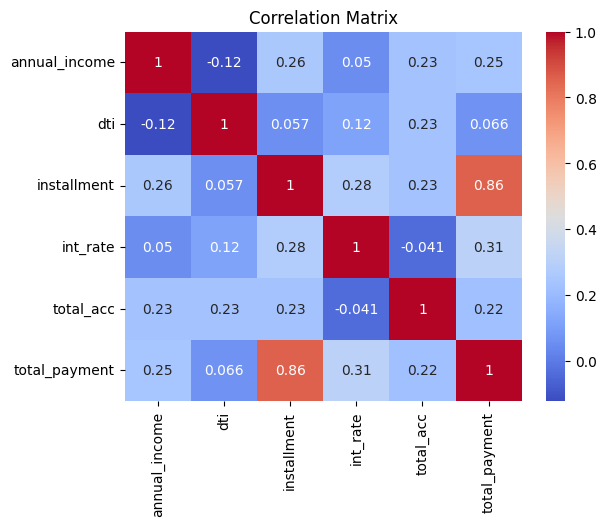

In [243]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("EDA").getOrCreate()

# Load the dataset
df = spark.read.csv('preprocessed_data1.csv', header=True, inferSchema=True)

# Select the relevant columns
selected_columns = ['annual_income', 'dti', 'installment', 'int_rate', 'total_acc', 'total_payment']

# Compute the correlation matrix
corr_matrix = df.select(selected_columns).toPandas().corr()

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



###**2: Generates bar plots showing the average loan amount for each category within categorical variables, aiding in understanding how these categories influence the loan amount.**
  The analysis reveals that, among the variables examined  "address_state_indexed", "application_type_indexed", "emp_title_indexed" exhibit relatively weaker associations with the target variable (loan amount), compared to other variables



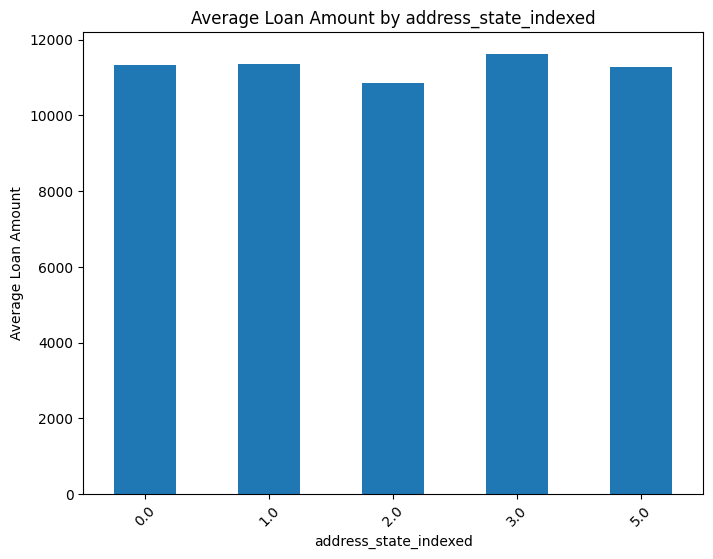

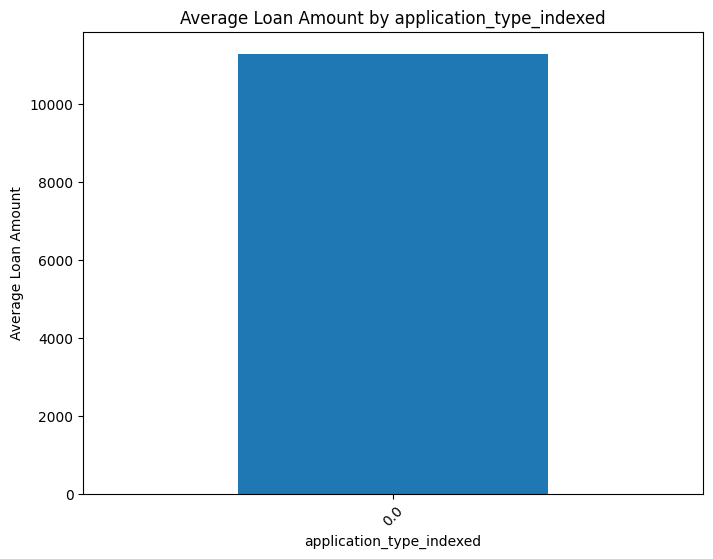

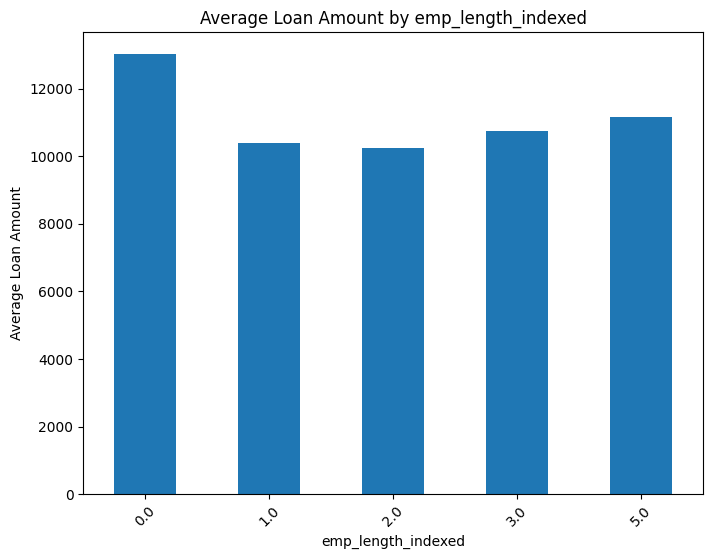

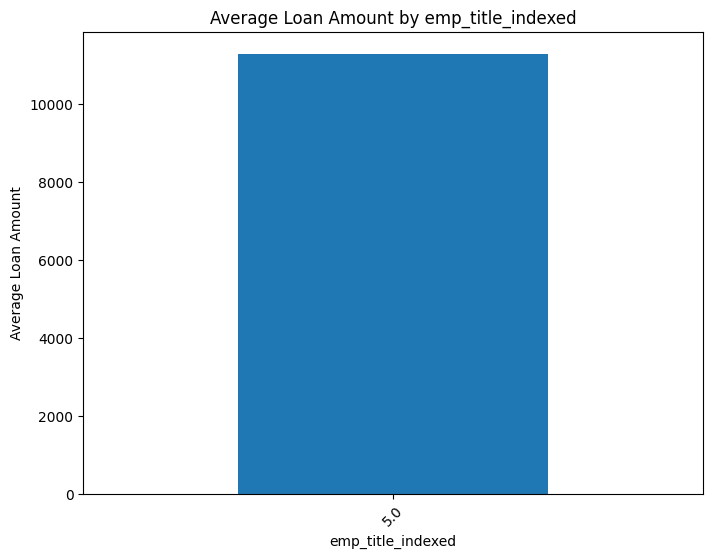

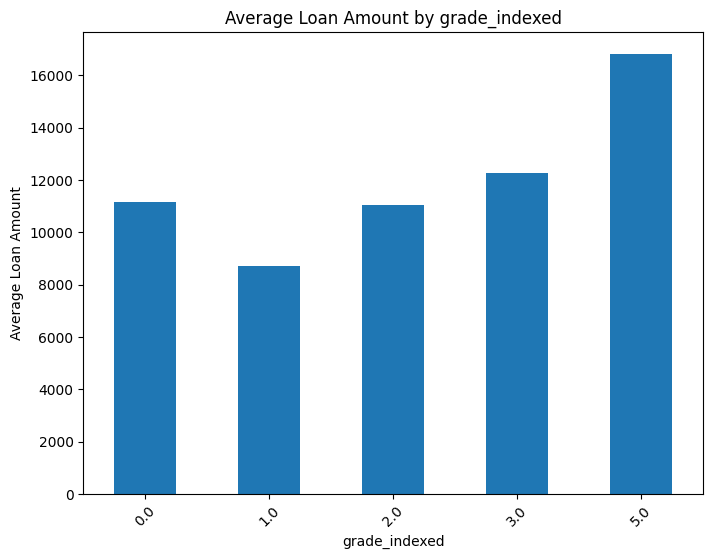

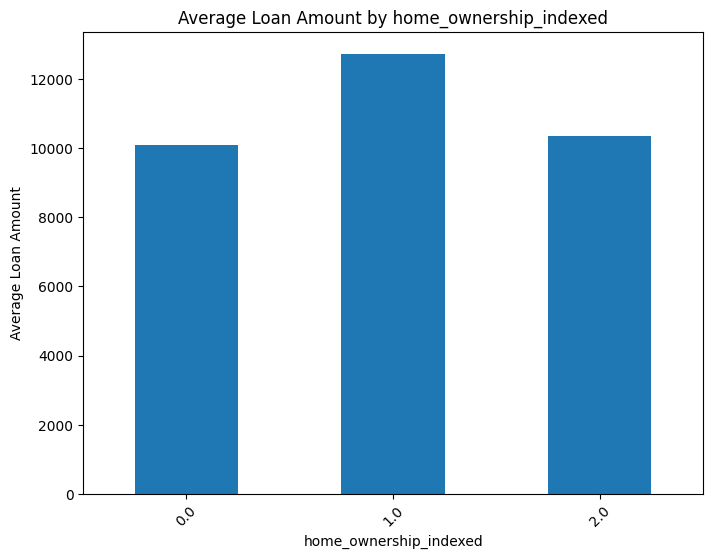

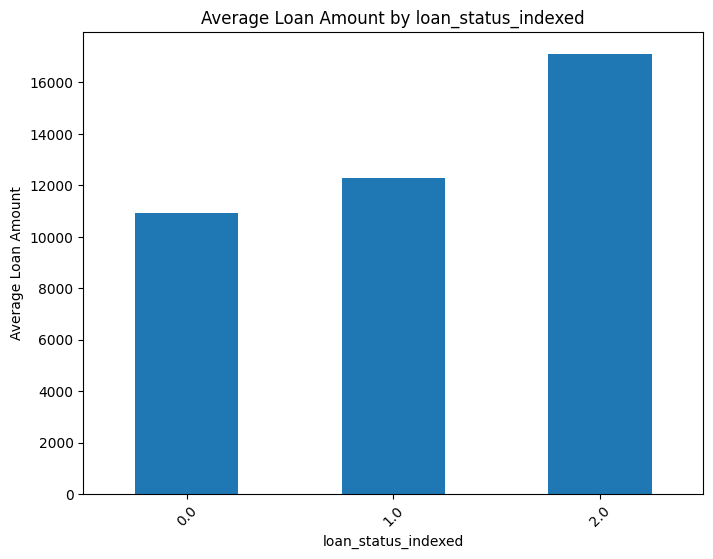

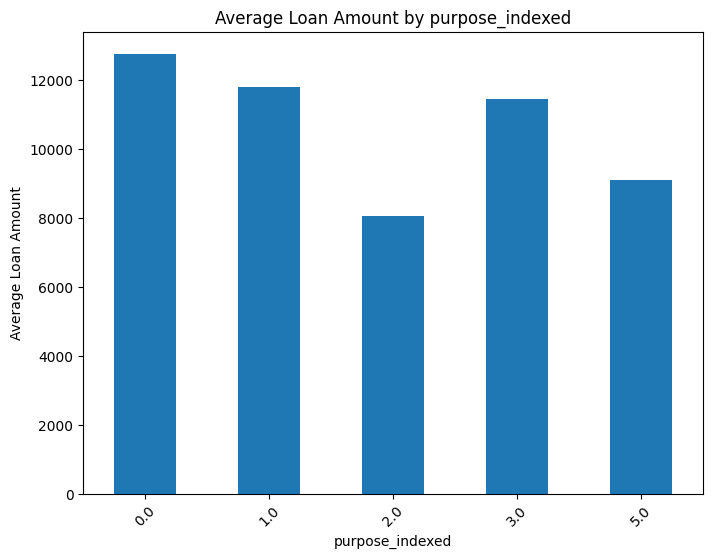

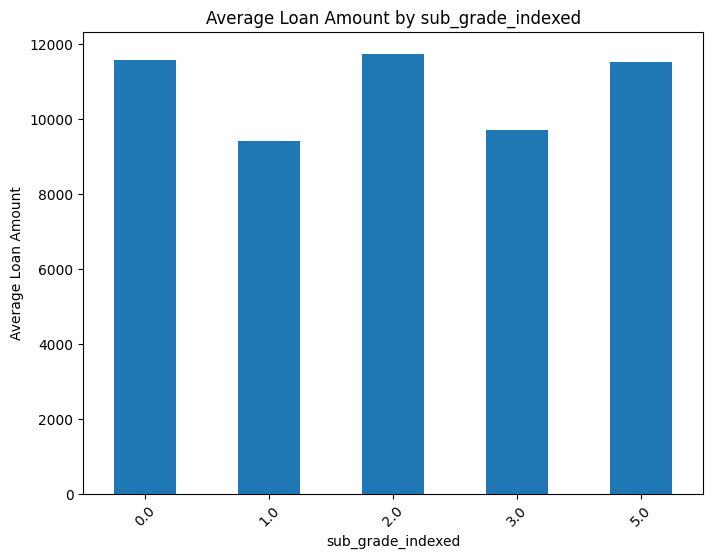

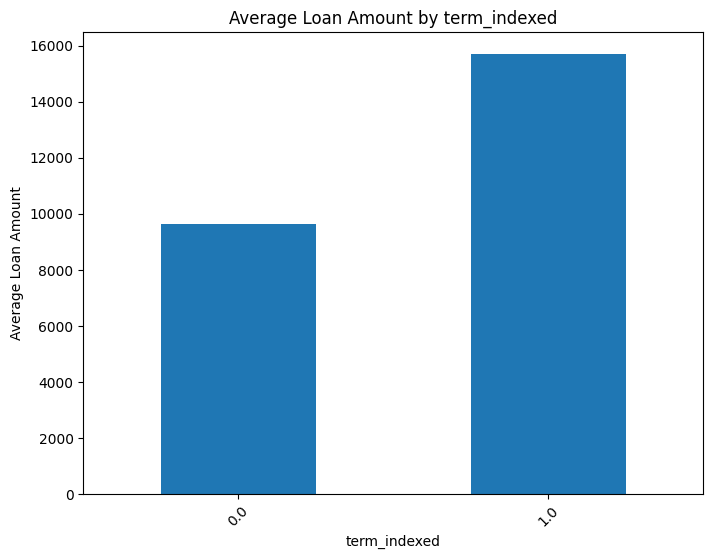

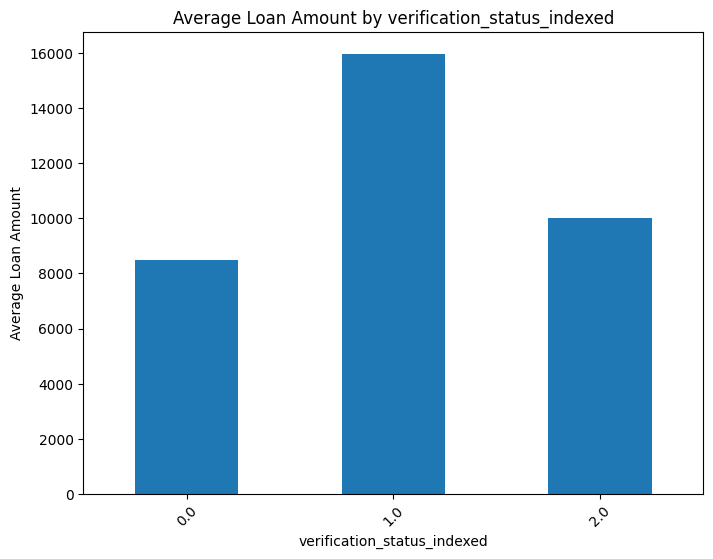

In [276]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("BarPlotExample").getOrCreate()


# Convert Spark DataFrame to Pandas for plotting
pdf = df.select("loan_amount",
                "address_state_indexed",
                "application_type_indexed",
                "emp_length_indexed",
                "emp_title_indexed",
                "grade_indexed",
                "home_ownership_indexed",
                "loan_status_indexed",
                "purpose_indexed",
                "sub_grade_indexed",
                "term_indexed",
                "verification_status_indexed").toPandas()

# Plot bar plots
for col_name in pdf.columns[1:]:  # Exclude loan_amount
    plt.figure(figsize=(8, 6))
    pdf.groupby(col_name)['loan_amount'].mean().plot(kind='bar')
    plt.title(f'Average Loan Amount by {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Average Loan Amount')
    plt.xticks(rotation=45)
    plt.show()


##**Input Variable Used**

###**Categorical Column**
 'emp_length_indexed',

 'grade_indexed',

 'home_ownership_indexed',

 'loan_status_indexed',

 'purpose_indexed',
 'sub_grade_indexed',

 'term_indexed',

 'verification_status_indexed'
###**Continuous Column**

'annual_income',

 'dti',

 'installment',

 'int_rate',

 'total_acc',





In [266]:
df.select('annual_income',
 'dti',
 'installment',
 'int_rate',
 'total_acc',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed').show(5)

+-------------+------+-----------+--------+---------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+
|annual_income|   dti|installment|int_rate|total_acc|grade_indexed|home_ownership_indexed|loan_status_indexed|purpose_indexed|sub_grade_indexed|term_indexed|verification_status_indexed|
+-------------+------+-----------+--------+---------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+
|      30000.0|  0.01|      59.83|  0.1527|        4|          2.0|                   0.0|                1.0|            5.0|              5.0|         1.0|                        2.0|
|      48000.0|0.0535|     109.43|  0.1864|        4|          5.0|                   0.0|                0.0|            5.0|              5.0|         0.0|                        2.0|
|      50000.0|0.2088|     421.65|  0.1596|       11|          2.0|   

##**Output Variable Used**

In [267]:
df.select('loan_amount').show(5)

+-----------+
|loan_amount|
+-----------+
|       2500|
|       3000|
|      12000|
|       4500|
|       3500|
+-----------+
only showing top 5 rows




##**Model Preperation:**

###**1: VectorAssembler to transform feature columns into a single vector column named "features"**
###**2: Select the input variables and target variables.**
###**3: Splitting the data into 80% training and 20% testing sets.**
###**4: Model: Linear Regression**









In [268]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# List of input column names
input_column_names = [
'annual_income',
 'dti',
 'installment',
 'int_rate',
 'total_acc',
 'emp_length_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed'
]

# Define the VectorAssembler using the input_column_names variable
featureassembler = VectorAssembler(inputCols=input_column_names, outputCol='Features')

# Transform the DataFrame
output = featureassembler.transform(df)

# Display the output DataFrame
output.show(2)

# Select the features and the target variable
to_predict = output.select("Features", 'loan_amount')

# Display the DataFrame to be predicted
to_predict.show(2)

# Split the data into training and testing sets
train_X, test_X = to_predict.randomSplit([0.8, 0.2])

# Define and train the Linear Regression model
reg = LinearRegression(featuresCol='Features', labelCol='loan_amount')
reg_model = reg.fit(train_X)




+-------------+------+-----------+--------+-----------+---------+-------------+---------------------+------------------------+------------------+-----------------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+--------------------+
|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|address_state_indexed|application_type_indexed|emp_length_indexed|emp_title_indexed|grade_indexed|home_ownership_indexed|loan_status_indexed|purpose_indexed|sub_grade_indexed|term_indexed|verification_status_indexed|            Features|
+-------------+------+-----------+--------+-----------+---------+-------------+---------------------+------------------------+------------------+-----------------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+--------------------+
|      30000.0|  0.01|      59.83|  0.1527|      

##**Prediction Part:**

###**1: Perform Prediction for loan amount using Testing Dataset**


In [269]:
# Make predictions on the test set
pred = reg_model.transform(test_X)

# Display the predictions
pred.show(5)

+--------------------+-----------+------------------+
|            Features|loan_amount|        prediction|
+--------------------+-----------+------------------+
|(13,[0,1,2,3,4],[...|       4750|4451.5038717261305|
|(13,[0,1,2,3,4],[...|      17000|17648.881777169056|
|(13,[0,1,2,3,4],[...|      10000|10388.684466236375|
|(13,[0,1,2,3,4],[...|      14200|14816.528675835558|
|(13,[0,1,2,3,4,5]...|       4000|3707.0955105301255|
+--------------------+-----------+------------------+
only showing top 5 rows





###**2: Model Evaluation**

R2 score measures how well the regression model captures the variation in the target variable.

R2 score closer to 1 are preferable, as they indicate a better fit of the model to the data.


In [270]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define and train the Linear Regression model
reg = LinearRegression(featuresCol='Features', labelCol='loan_amount')
reg_model = reg.fit(train_X)

# Make predictions on the test set
pred = reg_model.transform(test_X)

# Calculate R2 score
evaluator = RegressionEvaluator(labelCol="loan_amount", predictionCol="prediction", metricName="r2")
r2_score = evaluator.evaluate(pred)

# Display the R2 score
print("R2 Score:", r2_score)


R2 Score: 0.9435949055068614


In [271]:

coefficients = reg_model.coefficients





###**3. The coefficients of a trained regression model**
The magnitude of the coefficient indicates the strength of the relationship between the input variable and the target variable. Larger coefficients imply a larger impact on the target variable.

In [273]:
from pyspark.ml.linalg import DenseVector
import pandas as pd



coefficients_df = pd.DataFrame(list(zip(input_column_names, coefficients)), columns=['input_column_names', 'Coefficient'])


coefficients_df['Coefficient'] = coefficients_df['Coefficient'].abs()


coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

print(coefficients_df)


             input_column_names   Coefficient
3                      int_rate  16343.464283
11                 term_indexed   5116.146338
1                           dti    224.852615
8           loan_status_indexed     90.265908
7        home_ownership_indexed     43.160430
6                 grade_indexed     41.330445
2                   installment     32.754342
9               purpose_indexed     26.028865
12  verification_status_indexed     19.858943
10            sub_grade_indexed     18.947507
5            emp_length_indexed     18.778405
4                     total_acc      5.073801
0                 annual_income      0.001373


##**Business Translation:**

###**1: Automated Loan Decisions:**
The model helps quickly determine how much money a customer can borrow, saving time and effort compared to doing it manually.

###**2: Improved Accuracy:**
By looking at factors like job length, income, and interest rates, the model gives more accurate loan amounts, reducing the chance of lending too much or too little.

###**3: Personalized Loan Offers:**
The model creates loan offers that are customized to each customer’s financial situation, making them happier and more likely to trust the business.

###**4: Risk Mitigation:**
With better predictions, the business can spot high-risk loans and take steps to avoid them, reducing the chances of defaults and financial losses
###**5: Data-Driven Decisions:**
The model provides insights that help the business make smarter decisions based on data, improving overall planning and management.



